## Social Listening

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/institutohumai/talleres/blob/master/Twitter_Social_Listening_ejemplo.ipynb)

Con esta herramienta podemos buscar los últimos N tweets de un usuario O de un hashtag, ver en qué temas se agrupan, y aplicar un análisis de sentimiento por ejemplo con respecto a un tema en particular.

Instrucciones:

- Darle play a la primera celda
- Resetear: en el menu, elegir Runtime -> Restart runtime
- Poner los parámetros que se quieran (usuario y cantidad de tweets) y ejecutar!

Aclaración: puede tardar unos ~2-5 minutos, en especial la primera vez que se ejecuta.)

`__author__ = 'Matías Grinberg'`  
[Linkedin](https://ar.linkedin.com/in/matias-grinberg)

In [ ]:
#@title Darle play a esta celda y cuando termina, clickear en el menú "Runtime" y "Restart Runtime" 
%%capture
# Instalamos twint para bajar tweets
!pip3 install --upgrade -e git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip3 install --upgrade aiohttp_socks
!pip install tweet-preprocessor
!pip install umap-learn
!pip install sentence_transformers
!pip install hdbscan
!pip install transformers

In [ ]:
buscar_por = "usuario"  # @param ["usuario", "hashtag"]
usuario = "wef"  # @param {type:"string"}
hashtag = "artificialintelligence"  # @param {type:"string"}
desde = "2020-01-01"  # @param {type:"date"}
desde = desde + ' 00:00:00'
idioma = "en"  # @param ["en", "es"]
n = 1000  # @param {type:"integer"}
download_csv = False  

if idioma == "es":
    sentiment_model = "distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es"
elif idioma == "en":
    sentiment_model = "distilbert-base-uncased-finetuned-sst-2-english"
else:
    sentiment_model = "nlptown/bert-base-multilingual-uncased-sentiment"

import time
import re
import textwrap
import hdbscan
import nest_asyncio
import numpy as np
import seaborn as sns

# Hay que reiniciar la colab. Luego de eso, importamos
import twint
import umap
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pandas as pd
import plotly.graph_objects as go
import preprocessor as p

from transformers import pipeline
from io import BytesIO
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import requests as rq
from PIL import Image
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud
from IPython.utils import io

nest_asyncio.apply()
pd.options.mode.chained_assignment = None
now = time.strftime("%Y-%m-%d %H:%M:%S")

def make_cloud(text, img_url=None, width=800, height=800, plot=True, min_font_size=10):
    mask = None

    if img_url:
        mask = np.array(Image.open(BytesIO(rq.get(img_url).content)))
        mask[mask > 250] = 255
        image_colors = ImageColorGenerator(mask)
        width = mask.shape[1]
        height = mask.shape[0]

    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color="white",
        stopwords=stopwords,
        random_state=42,
        min_font_size=min_font_size,
        mask=mask,
        color_func=image_colors if img_url else None,
    ).generate(text)

    if plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()

    return wordcloud


# import nltk
# nltk.download('wordnet')

# lemma = nltk.wordnet.WordNetLemmatizer()

# class LemmaTfidfVectorizer(TfidfVectorizer):
#     def build_analyzer(self):
#         analyzer = super(LemmaTfidfVectorizer, self).build_analyzer()
#         return lambda doc: [lemma.lemmatize(w) for w in analyzer(doc)]

# vectorizer = LemmaTfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(tweets['tweet'])
# embeddings = X.toarray()
# embeddings.shape, vectorizer.get_feature_names()[100:110]


def c_tf_idf(documents, m, ngram_range=(1, 1), stop_words="spanish"):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(
        documents
    )
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.cluster)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {
        label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1]
        for i, label in enumerate(labels)
    }
    return top_n_words


def plot_clusters(all_coords: pd.DataFrame, clusters):
    """all_coords should have title, text, cluster, and color cols. Constructed like:

    all_coords = pd.DataFrame(data = reduced, columns = ['x', 'y','z'])
    all_coords['title'] = labels
    all_coords['text'] = data
    all_coords['cluster'] = clusters"""
    fig = go.Figure()

    # Group titles and get top N words per cluster
    docs_per_topic = all_coords.groupby(["cluster"], as_index=False).agg(
        {"text": " ".join}
    )
    tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=len(clusters), stop_words=[])
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=15)
    # pprint({k: [w for w,r in v] for k,v in top_n_words.items()}, compact=True)

    # @title 3D Plot
    max_labels = 3
    words_per_cluster = {
        n: [p for p, score in l[:max_labels]] for n, l in top_n_words.items()
    }

    # Clusters
    for c in np.unique(clusters):
        coords = all_coords[all_coords.cluster == c]
        fig.add_trace(
            go.Scatter3d(
                x=coords["x"],
                y=coords["y"],
                z=coords["z"],
                mode="markers",
                marker_size=8,
                marker_line_width=1,
                name=f"Cº{str(c)}: {'<br>'.join(textwrap.wrap(' '.join(words_per_cluster[c]), width=50))}",
                marker_color=coords["color"],
                text=coords["text"].apply(
                    lambda txt: "<br>".join(textwrap.wrap(txt, width=50))
                ),
                hoverinfo="text",
            )
        )
    return fig


def get_hashtag(hashtag, until=now, since=desde, n=None):
    c = twint.Config()
    c.Profile_full = True
    c.Pandas = True
    c.Search = hashtag
    c.Show_hashtags = True
    c.Until = until
    c.Since = since
    c.Count = True
    c.Retweets = True
    c.Hide_output = True
    if n:
        c.Limit = n

    c.Store_csv = True
    c.Output = until + " to " + since + ".csv"

    twint.run.Search(c)
    tweets = twint.output.panda.Tweets_df[["date", "tweet", "hashtags"]]
    return tweets


def get_user(user, until=now, since=desde, n=None):
    # Descargamos tweets
    c = twint.Config()
    c.Username = user
    c.Until = until
    c.Since = since
    c.Hide_output = True
    c.Pandas = True
    if n:
        c.Limit = n
    twint.run.Search(c)
    tweets = twint.output.panda.Tweets_df[["date", "tweet", "hashtags"]]
    return tweets

print("Descargando Tweets...")

if buscar_por == "usuario":
    func = get_user
    query = usuario
else:
    func = get_hashtag
    query = hashtag

tweets = func(query, n=n)

if download_csv:
    # Descargar csv a local
    tweets.to_csv(f"{user}.csv")
    from google.colab import files

    files.download(f"{user}.csv")
  
print("Despertando IAs...")
with io.capture_output() as captured:
    sentence_transformers_model = (
        "sentence-transformers/distilbert-multilingual-nli-stsb-quora-ranking"
    )
    model = SentenceTransformer(sentence_transformers_model)
    get_sentiment = pipeline("sentiment-analysis", model=sentiment_model)

print("Procesando...")
tweets["tweet"] = tweets.apply(lambda x: p.clean(x["tweet"]), axis=1)

# Por tweets iguales con distintas URLs
tweets = tweets.drop_duplicates("tweet")
tweets = tweets.loc[(tweets["tweet"].str.len() > 1), :]

embeddings = model.encode(tweets["tweet"].tolist())
reducer = umap.UMAP(n_components=3).fit(embeddings)
umap_embeddings = reducer.transform(embeddings)
cluster = hdbscan.HDBSCAN().fit(umap_embeddings)

data = tweets["tweet"].tolist()
clusters = cluster.labels_

all_coords = pd.DataFrame(data=umap_embeddings, columns=["x", "y", "z"])
all_coords["text"] = data
all_coords["cluster"] = clusters

# for style in ['YlGnBu']:
style = "viridis_r"
# We generate a list of colors
palette = sns.color_palette(style, n_colors=len(np.unique(clusters)) + 1).as_hex()
all_coords["color"] = [palette[i] for i in clusters]

fig = plot_clusters(all_coords, clusters)
fig.update_layout(
    width=1000,
    height=800,
    autosize=False,
    showlegend=True,
    scene={"aspectmode": "cube"},
)
fig.show()

Descargando Tweets...
Despertando IAs...
Procesando...


Análisis de polaridad, positivo-negativo, para los tweets cuyos hashtags contengan algun término de la búsqueda. Se aplica a todos si se deja vacío.

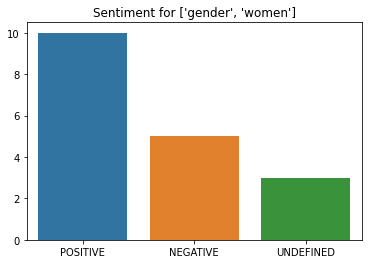

In [ ]:
#@title Sentiment Analysis
terminos = 'gender, women' #@param {'type':'string'}
terminos = re.findall('\w+', terminos)
#terminos = ['climate', 'emissions', 'environment', 'nature', 'forest']

tweets['search'] = tweets.apply(lambda x: any([s in y for s in terminos for y in x['hashtags']]) or 
                                any([s in y for s in terminos for y in x['tweet']]), axis=1)
search_tweets = tweets[tweets['search'] == 1]

th = 0.85
search_tweets['sentiment'] = [d['label'] if d['score'] > 0.85 else 'UNDEFINED' for d in get_sentiment(search_tweets['tweet'].values.tolist())]
x=search_tweets['sentiment'].value_counts()
sns.barplot(x=x.index, y=x.values, orient='v')
plt.title(f'Sentiment for {terminos}');

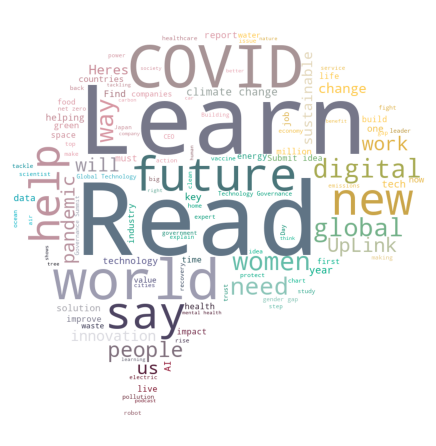

In [ ]:
#@title Word Cloud
img_url = "https://toppng.com/uploads/preview/human-brain-png-high-quality-image-brain-clipart-115630224411rqb2dvotv.png"
text = " ".join(tweets["tweet"].tolist())
make_cloud(text, img_url);